In [132]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)

In [396]:
from pbdlib import plot_gmm

In [133]:
from scipy.special import digamma
from scipy.special import logsumexp

In [221]:
from matplotlib.patches import Ellipse    
        
def plot_gaussian(mus, sigmas, ax, weights = None):
    K = int(mus.shape[0])
    #K = 2
    if weights is None:
        weights = np.ones(K)/K
    
    for k in range(K):
        sigma = sigmas[k]
        val,vec = np.linalg.eig(sigma)
        angle = np.arctan2(vec[0,1], vec[0,0])
        ells = Ellipse(xy=mus[k],
                width=4.*np.sqrt(val[0]), height=4.*np.sqrt(val[1]),
                angle=np.rad2deg(angle))
        ells.set_alpha(weights[k]*3)
        ax.add_artist(ells)
    plt.xlim(0, 10)
    plt.ylim(-2, 2)
    return

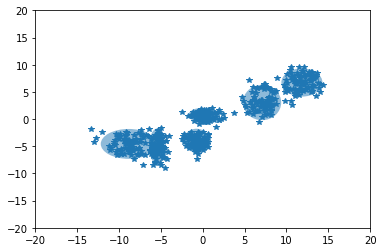

In [202]:
import numpy as np
import matplotlib.pyplot as plt
D = 2
K_true = 6
N = 500
is_plot = True

mus_true = []
sigmas_true = []
samples = []
for k in range(K_true):
    mu = 5*np.random.normal(size=D)
    sigma = 3*np.diag(np.random.rand(D))
    sample = np.random.multivariate_normal(mu, cov = sigma, size = N/K_true)
    mus_true.append(mu)
    sigmas_true.append(sigma)
    samples.append(sample)
    
x = np.vstack(samples)
mus_true = np.array(mus_true)
sigmas_true = np.array(sigmas_true)

if is_plot:
    fig,ax = plt.subplots()
    plot_gaussian(mus_true,sigmas_true,ax)
    plt.plot(x[:,0],x[:,1],'*')

### Define class for GMM and GMR

In [421]:
from sklearn.cluster import KMeans
class GMM():
    def __init__(self, n_comp = 10, D = 1, K = 2, weight_concentration = 0.1):
        self.n_comp = n_comp
        self.D = D
        self.K = K

        #pi params
        self.alpha0 = np.ones(K)*weight_concentration
        self.alpha = np.copy(self.alpha0)

        #mu and sigma params
        self.betha0 = 1
        self.betha = np.ones(self.K)
        self.mu0 = np.zeros(self.D)
        self.W0 = 100*np.eye(self.D)
        self.v0 = self.D
        #
        self.W = [np.eye(self.D) for i in range(self.K)]
        self.v = np.ones(self.K)*self.D
        
    def fit(self,x, num_iter = 10):
        self.x = x
        self.N = self.x.shape[0]
        kMM = KMeans(n_clusters=self.K).fit(x)
        
        #self.mu = kMM.cluster_centers_
        self.mu = x[np.random.choice(len(x),size = self.K)]
        for i in range(num_iter):
            self.expectation()
            self.maximization()
            
        self.sigma = []
        for k in range(self.K):
            sigma = np.linalg.inv(self.v[k]*self.W[k])
            self.sigma.append(sigma)

        self.weights = self.alpha/np.sum(self.alpha)
        
        print 'mus', self.mu
        print 'pis', self.weights
        
    def log_normalize(self,x):
        return x - logsumexp(x)

    def expectation(self):
        self.ln_ro = np.zeros([self.N,self.K])
        self.ro = np.zeros([self.N,self.K])

        print 'Calculating ro'
        tic = time.time()
        for k in range(self.K):
            E_s = self.D*np.log(2) + np.log(np.linalg.det(self.W[k])) + np.sum([digamma((self.v[k] + 1 - i)/2.) \
                                                                           for i in range(self.D)])
            E_pi = digamma(self.alpha[k]) - digamma(np.sum(self.alpha))
            E_2 = self.D*np.log(2*np.pi)
            for n in range(self.N):
                E_ms = self.D/self.betha[k] + self.v[k]*np.dot(self.x[n] - self.mu[k], np.dot(self.W[k], \
                                                                                self.x[n] - self.mu[k]))
                self.ln_ro[n,k] = E_pi + 0.5*E_s - 0.5*E_2 - 0.5*E_ms

        for n in range(self.N):        
            self.ln_ro[n,:] = log_normalize(self.ln_ro[n,:])
            self.ro[n,:] = np.exp(self.ln_ro[n,:])
        toc = time.time()
        print toc-tic


        self.Nks = np.array([np.sum(self.ro[:,k]) for k in range(self.K)])

        self.xks = np.dot(self.ro.T, self.x)
        for k in range(self.K):
            self.xks[k,:] /= self.Nks[k]


        print 'Calculating Sk' 
        self.Sks = []
        for k in range(self.K):
            Sk = np.zeros([self.D,self.D])
            for n in range(self.N):
                Sk += self.ro[n,k]*np.outer(self.x[n]-self.xks[k], self.x[n]-self.xks[k])
            Sk /= self.Nks[k]
            self.Sks.append(Sk)

        toc = time.time()
        print toc-tic
             
    def maximization(self):
        self.alpha = self.alpha0 + self.Nks
        self.betha = self.betha0 + self.Nks

        for k in range(self.K):
            self.mu[k] = (self.betha0*self.mu0 + self.Nks[k]*self.xks[k])/self.betha[k]
            Wk_inv = np.linalg.inv(self.W0) + self.Nks[k]*self.Sks[k] + np.outer(self.xks[k]-self.mu0, \
                                    self.xks[k]-self.mu0)*self.betha0*self.Nks[k]/(self.betha0+self.Nks[k])
            self.W[k] = np.linalg.inv(Wk_inv)
            self.v[k] = self.v0 + self.Nks[k]
            
    def plot(self):
        fig,ax = plt.subplots()
        plot_gaussian(self.mu, self.sigma, ax, self.weights )


In [422]:
gmm = GMM(D = 2, K = 10, weight_concentration=2)

gmm.fit(x,num_iter = 100)

Calculating ro
0.0344099998474
Calculating Sk
0.0741498470306
Calculating ro
0.0311579704285
Calculating Sk
0.0699939727783
Calculating ro
0.0310230255127
Calculating Sk
0.069011926651
Calculating ro
0.0326879024506
Calculating Sk
0.0687029361725
Calculating ro
0.0304338932037
Calculating Sk
0.0683438777924
Calculating ro
0.030394077301
Calculating Sk
0.0682120323181
Calculating ro
0.0352251529694
Calculating Sk
0.0749490261078
Calculating ro
0.0317690372467
Calculating Sk
0.0699281692505
Calculating ro
0.0306239128113
Calculating Sk
0.0681779384613
Calculating ro
0.0329449176788
Calculating Sk
0.0710778236389
Calculating ro
0.0306010246277
Calculating Sk
0.0681688785553
Calculating ro
0.0303552150726
Calculating Sk
0.0678761005402
Calculating ro
0.033322095871
Calculating Sk
0.0715839862823
Calculating ro
0.0304560661316
Calculating Sk
0.0682291984558
Calculating ro
0.031179189682
Calculating Sk
0.0690321922302
Calculating ro
0.0307588577271
Calculating Sk
0.0686519145966
Calculating 

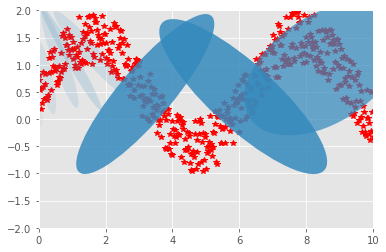

In [423]:
fig,ax = plt.subplots()
plot_gaussian(gmm.mu, gmm.sigma, ax, gmm.weights)
plt.plot(x[:,0], x[:,1], '*r',zorder=1)

### Try on Data 

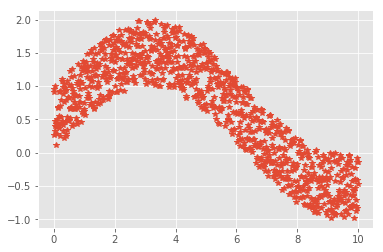

In [475]:
x_in = np.arange(0,10,0.01)
x_out = np.sin(0.5*x_in) + np.random.rand(len(x_in))*1
plt.plot(x_in,x_out,'*')

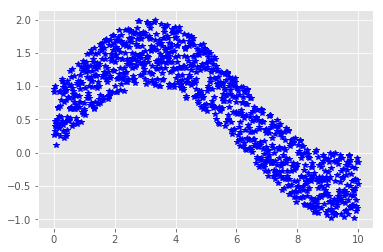

In [476]:
x = np.vstack([x_in, x_out]).T
plt.plot(x[:,0],x[:,1],'*b',zorder=1)

In [477]:
gmm = GMM(n_comp=10, D=2,K=10,weight_concentration=100)

In [478]:
gmm.fit(x,num_iter = 100)

Calculating ro
0.0614259243011
Calculating Sk
0.136837005615
Calculating ro
0.0608580112457
Calculating Sk
0.136938095093
Calculating ro
0.0636210441589
Calculating Sk
0.138913154602
Calculating ro
0.0597109794617
Calculating Sk
0.134042978287
Calculating ro
0.0662560462952
Calculating Sk
0.139366865158
Calculating ro
0.0603289604187
Calculating Sk
0.135385990143
Calculating ro
0.065840959549
Calculating Sk
0.141640901566
Calculating ro
0.0626060962677
Calculating Sk
0.141466140747
Calculating ro
0.0615661144257
Calculating Sk
0.13894200325
Calculating ro
0.0634610652924
Calculating Sk
0.136178970337
Calculating ro
0.0599491596222
Calculating Sk
0.135259151459
Calculating ro
0.06307721138
Calculating Sk
0.132302999496
Calculating ro
0.0593180656433
Calculating Sk
0.133912086487
Calculating ro
0.0636019706726
Calculating Sk
0.136596918106
Calculating ro
0.0605270862579
Calculating Sk
0.13707613945
Calculating ro
0.0632619857788
Calculating Sk
0.131642103195
Calculating ro
0.060973882675

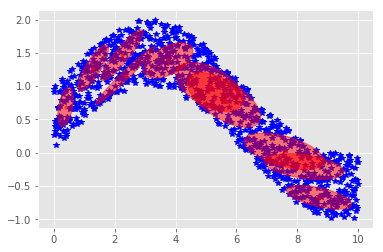

In [479]:
means, covs = filter_gaussian(gmm.mu, gmm.sigma, gmm.weights,threshold=0.01)
plot_gmm(means,covs)
plt.plot(x[:,0],x[:,1],'*b',zorder=1)

In [488]:
def filter_gaussian(means_, covariances_, weights_, threshold = 0.01):
    means = [] 
    covs = []
    for i,w in enumerate(weights_):
        if w > threshold:
            means.append(means_[i])
            covs.append(covariances_[i])
    
    means = np.array(means)
    covs = np.array(covs)
    return means,covs

In [490]:
from sklearn.mixture import GaussianMixture
gmm_sk = GaussianMixture(n_components=10)
gmm_sk.fit(x)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

ValueError: shapes (28,28) and (2,35) not aligned: 28 (dim 1) != 2 (dim 0)

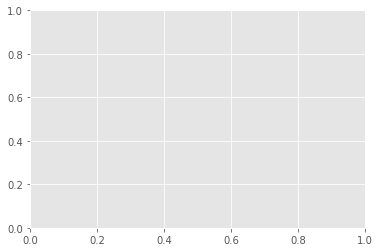

In [489]:
fig,ax = plt.subplots()
plot_gmm(gmm_sk.means_, gmm_sk.covariances_)
plt.plot(x[:,0],x[:,1],'*b',zorder=1)

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
bgmm_sk = BayesianGaussianMixture(n_components=10, weight_concentration_prior_type='dirichlet_distribution')
bgmm_sk.fit(x)

means, covs = filter_gaussian(bgmm_sk.means_, bgmm_sk.covariances_, bgmm_sk.weights_,threshold=0.01)
plot_gmm(means,covs)
plt.plot(x[:,0],x[:,1],'*')

### GMR 

In [480]:
from scipy.stats import multivariate_normal as mvn

In [496]:
class GMR():
    def __init__(self, GMM, n_in, n_out):
        self.GMM = GMM
        self.n_in = n_in
        self.n_out = n_out
        #segment the gaussian components
        self.mu_x = []
        self.mu_y = []
        self.sigma_xx = []
        self.sigma_yy = []
        self.sigma_xy = []
        for k in range(self.GMM.K):
            self.mu_x.append(self.GMM.mu[k][0:self.n_in])        
            self.mu_y.append(self.GMM.mu[k][self.n_in:])        
            self.sigma_xx.append(self.GMM.sigma[k][0:self.n_in, 0:self.n_in])        
            self.sigma_yy.append(self.GMM.sigma[k][self.n_in:, self.n_in:])        
            self.sigma_xy.append(self.GMM.sigma[k][0:self.n_in, self.n_in:])
            
        self.mu_x = np.array(self.mu_x)
        self.mu_y = np.array(self.mu_y)
        self.sigma_xx = np.array(self.sigma_xx)
        self.sigma_yy = np.array(self.sigma_yy)
        self.sigma_xy = np.array(self.sigma_xy)
        
    def predict(self,x):
        h = []
        mu = []        
        sigma = []

        for k in range(self.GMM.K):
            h.append(self.GMM.weights[k]*mvn(mean = self.mu_x[k], cov = self.sigma_xx[k]).pdf(x))
            mu.append(self.mu_y[k] + np.dot(self.sigma_xy[k].T, \
                                            np.dot(np.linalg.inv(self.sigma_xx[k]), x - self.mu_x[k])))
            sigma.append(self.sigma_yy[k]- np.dot(self.sigma_xy[k].T, np.dot(np.linalg.inv(self.sigma_xx[k]), self.sigma_xy[k])))
        
        h = np.array(h)
        h = h/np.sum(h)
        mu = np.array(mu)
        
        sigma_one = np.zeros([self.n_out, self.n_out])
        mu_one = np.zeros(self.n_out)
        for k in range(self.GMM.K):
            sigma_one += h[k]*(sigma[k] + np.outer(mu[k],mu[k]))
            mu_one += h[k]*mu[k]
            
        sigma_one -= np.outer(mu_one, mu_one)
        return mu_one, sigma_one

In [497]:
gmr = GMR(gmm, 1, 1)

In [498]:
x_i = 0.3
print gmr.predict(x_i)

[0.   0.12 0.   0.   0.   0.   0.   0.   0.01 0.  ]
[0.   0.89 0.   0.   0.   0.03 0.   0.01 0.07 0.  ]
[[1.79]
 [0.64]
 [0.8 ]
 [1.91]
 [0.15]
 [0.26]
 [0.25]
 [0.5 ]
 [0.71]
 [0.83]]
(array([0.64]), array([[0.07]]))


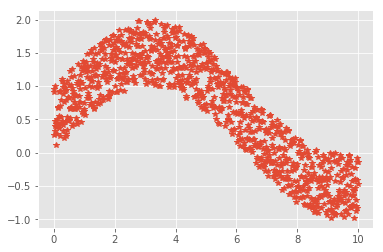

In [484]:
plt.plot(x[:,0],x[:,1],'*')

In [513]:
y_pred = []
y_cov = []
x_test = np.arange(-5,20,0.2)
for x_i in x_test:
    m, cov = (gmr.predict(x_i))
    y_pred.append(m)
    y_cov.append(cov)
    
y_pred = np.array(y_pred)
y_cov = np.array(y_cov)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 2.67]
 [-1.97]
 [-0.1 ]
 [ 3.03]
 [ 0.66]
 [-2.06]
 [ 0.55]
 [-2.14]
 [-2.28]
 [ 1.42]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 2.63]
 [-1.87]
 [-0.07]
 [ 2.99]
 [ 0.65]
 [-1.97]
 [ 0.54]
 [-2.04]
 [-2.17]
 [ 1.4 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 2.6 ]
 [-1.78]
 [-0.03]
 [ 2.95]
 [ 0.63]
 [-1.88]
 [ 0.53]
 [-1.94]
 [-2.05]
 [ 1.38]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 2.57]
 [-1.68]
 [ 0.  ]
 [ 2.91]
 [ 0.61]
 [-1.8 ]
 [ 0.52]
 [-1.84]
 [-1.94]
 [ 1.36]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 2.53]
 [-1.58]
 [ 0.03]
 [ 2.86]
 [ 0.59]
 [-1.71]
 [ 0.51]
 [-1.74]
 [-1.83]
 [ 1.33]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 2.5 ]
 [-1.48]
 [ 0.07]
 [ 2.82]
 [ 0.57]
 [-1.62]
 [ 0.49]
 [-1.64]
 [-1.71]
 [ 1.31]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 2.4

[0.   0.   0.   0.   0.03 0.   0.02 0.   0.   0.01]
[0.   0.   0.   0.   0.51 0.   0.32 0.   0.   0.17]
[[ 0.25]
 [ 5.23]
 [ 2.38]
 [-0.05]
 [-0.75]
 [ 4.33]
 [-0.29]
 [ 5.13]
 [ 5.96]
 [-0.2 ]]
[0.   0.   0.   0.   0.02 0.   0.02 0.   0.   0.01]
[0.   0.   0.   0.   0.52 0.   0.32 0.   0.   0.16]
[[ 0.21]
 [ 5.33]
 [ 2.41]
 [-0.1 ]
 [-0.77]
 [ 4.42]
 [-0.3 ]
 [ 5.23]
 [ 6.07]
 [-0.22]]
[0.   0.   0.   0.   0.02 0.   0.01 0.   0.   0.01]
[0.   0.   0.   0.   0.52 0.   0.33 0.   0.   0.15]
[[ 0.18]
 [ 5.43]
 [ 2.45]
 [-0.14]
 [-0.79]
 [ 4.51]
 [-0.31]
 [ 5.33]
 [ 6.18]
 [-0.25]]
[0.   0.   0.   0.   0.02 0.   0.01 0.   0.   0.  ]
[0.   0.   0.   0.   0.52 0.   0.33 0.   0.   0.14]
[[ 0.15]
 [ 5.53]
 [ 2.48]
 [-0.18]
 [-0.81]
 [ 4.6 ]
 [-0.32]
 [ 5.43]
 [ 6.29]
 [-0.27]]
[0.   0.   0.   0.   0.01 0.   0.01 0.   0.   0.  ]
[0.   0.   0.   0.   0.52 0.   0.34 0.   0.   0.14]
[[ 0.11]
 [ 5.63]
 [ 2.52]
 [-0.22]
 [-0.83]
 [ 4.68]
 [-0.33]
 [ 5.53]
 [ 6.41]
 [-0.29]]
[0.   0.   0.   0.   0.01

In [526]:
%matplotlib qt

In [535]:
plt.plot(x_test, y_pred,'*b')
plt.plot(x_test, y_pred[:,0]+np.sqrt(y_cov[:,0,0]),'*r',markersize=4)
plt.plot(x_test,  y_pred[:,0]- np.sqrt(y_cov[:,0,0]),'*r',markersize=4)  
plt.plot(x_in, x_out, '*k')
plot_gmm(gmm.mu, gmm.sigma)
plt.show()

In [529]:
y_pred.shape

(125, 1)

In [504]:
y_cov.shape

(1000, 1, 1)

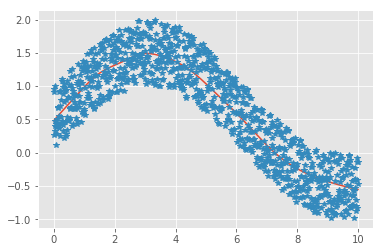

In [486]:
plt.plot(x_in, y_pred)
plt.plot(x[:,0],x[:,1],'*')

In [487]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')['sarcos_inv']
data_test = loadmat('data/sarcos_inv_test.mat')['sarcos_inv_test']

data_train.shape

x = data_train

D = x.shape[1]
K = 100
N = x.shape[0]